<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2024/blob/main/Bayesian_curve_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [100/10000], ELBO: 21955.8789
Epoch [200/10000], ELBO: 125044.3359
Epoch [300/10000], ELBO: 19256.0352
Epoch [400/10000], ELBO: 2699.2588
Epoch [500/10000], ELBO: 1358.0505
Epoch [600/10000], ELBO: 1983.6917
Epoch [700/10000], ELBO: 2992.7339
Epoch [800/10000], ELBO: 974.4955
Epoch [900/10000], ELBO: 1417.2831
Epoch [1000/10000], ELBO: 20425.7656
Epoch [1100/10000], ELBO: 1074.5349
Epoch [1200/10000], ELBO: 5047.0591
Epoch [1300/10000], ELBO: 2872.8274
Epoch [1400/10000], ELBO: 988.6727
Epoch [1500/10000], ELBO: 1777.2341
Epoch [1600/10000], ELBO: 2760.8047
Epoch [1700/10000], ELBO: 2909.8926
Epoch [1800/10000], ELBO: 1023.1545
Epoch [1900/10000], ELBO: 697.2111
Epoch [2000/10000], ELBO: 931.3675
Epoch [2100/10000], ELBO: 1585.8160
Epoch [2200/10000], ELBO: 2358.4490
Epoch [2300/10000], ELBO: 1670.5719
Epoch [2400/10000], ELBO: 1900.7065
Epoch [2500/10000], ELBO: 8712.2520
Epoch [2600/10000], ELBO: 3193.8730
Epoch [2700/10000], ELBO: 2047.0564
Epoch [2800/10000], ELBO: 934.6063
E

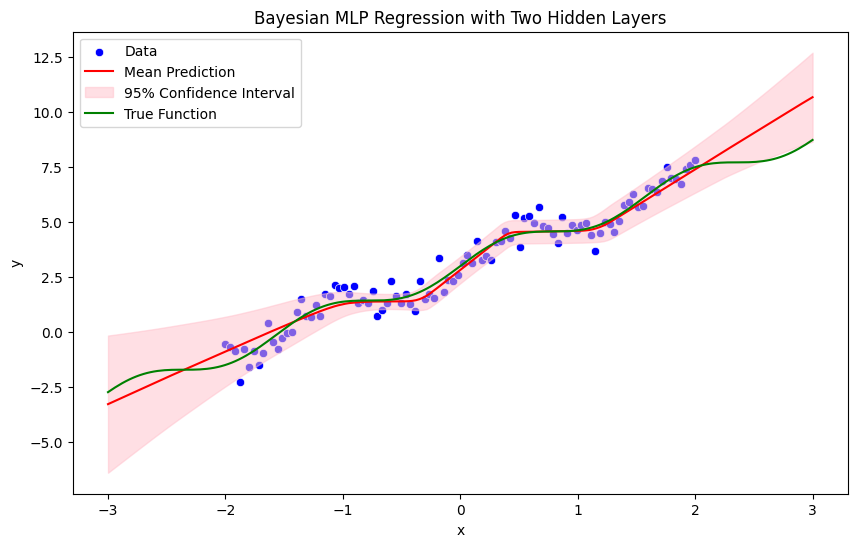

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the true function (for simulation)
def true_function(x):
    return 2 * x + 3 + 0.5 * torch.sin(4 * x)

# Generate synthetic data
np.random.seed(42)
torch.manual_seed(42)

n_samples = 100
x_data = torch.linspace(-1, 1, n_samples).unsqueeze(1)
y_data = true_function(x_data) + torch.randn(n_samples, 1) * 0.5  # Add noise

# Define the Bayesian MLP Model with two hidden layers
class BayesianMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(BayesianMLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim

        # Prior on weights and biases
        self.prior_mean = torch.zeros(input_dim, hidden_dim1)
        self.prior_std = torch.ones(input_dim, hidden_dim1)
        self.prior = dist.Normal(self.prior_mean, self.prior_std)

        # Variational parameters for weights and biases
        self.fc1_mean = nn.Parameter(torch.randn(input_dim, hidden_dim1))
        self.fc1_logstd = nn.Parameter(torch.randn(input_dim, hidden_dim1))

        self.fc2_mean = nn.Parameter(torch.randn(hidden_dim1, hidden_dim2))
        self.fc2_logstd = nn.Parameter(torch.randn(hidden_dim1, hidden_dim2))

        self.fc3_mean = nn.Parameter(torch.randn(hidden_dim2, output_dim))
        self.fc3_logstd = nn.Parameter(torch.randn(hidden_dim2, output_dim))

        self.bias1_mean = nn.Parameter(torch.randn(hidden_dim1))
        self.bias1_logstd = nn.Parameter(torch.randn(hidden_dim1))

        self.bias2_mean = nn.Parameter(torch.randn(hidden_dim2))
        self.bias2_logstd = nn.Parameter(torch.randn(hidden_dim2))

        self.bias3_mean = nn.Parameter(torch.randn(output_dim))
        self.bias3_logstd = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):
        # Sample weights and biases from variational distribution
        fc1_std = torch.exp(self.fc1_logstd)
        fc2_std = torch.exp(self.fc2_logstd)
        fc3_std = torch.exp(self.fc3_logstd)
        bias1_std = torch.exp(self.bias1_logstd)
        bias2_std = torch.exp(self.bias2_logstd)
        bias3_std = torch.exp(self.bias3_logstd)

        fc1_dist = dist.Normal(self.fc1_mean, fc1_std)
        fc2_dist = dist.Normal(self.fc2_mean, fc2_std)
        fc3_dist = dist.Normal(self.fc3_mean, fc3_std)
        bias1_dist = dist.Normal(self.bias1_mean, bias1_std)
        bias2_dist = dist.Normal(self.bias2_mean, bias2_std)
        bias3_dist = dist.Normal(self.bias3_mean, bias3_std)

        fc1_sample = fc1_dist.rsample()
        fc2_sample = fc2_dist.rsample()
        fc3_sample = fc3_dist.rsample()
        bias1_sample = bias1_dist.rsample()
        bias2_sample = bias2_dist.rsample()
        bias3_sample = bias3_dist.rsample()

        # Compute the output
        x = torch.relu(x @ fc1_sample + bias1_sample)
        x = torch.relu(x @ fc2_sample + bias2_sample)
        return x @ fc3_sample + bias3_sample

    def kl_divergence(self):
        # Compute KL divergence between variational distribution and prior
        fc1_std = torch.exp(self.fc1_logstd)
        fc2_std = torch.exp(self.fc2_logstd)
        fc3_std = torch.exp(self.fc3_logstd)
        bias1_std = torch.exp(self.bias1_logstd)
        bias2_std = torch.exp(self.bias2_logstd)
        bias3_std = torch.exp(self.bias3_logstd)

        fc1_kl = dist.kl_divergence(dist.Normal(self.fc1_mean, fc1_std), self.prior).sum()
        fc2_kl = dist.kl_divergence(dist.Normal(self.fc2_mean, fc2_std), self.prior).sum()
        fc3_kl = dist.kl_divergence(dist.Normal(self.fc3_mean, fc3_std), self.prior).sum()
        bias1_kl = dist.kl_divergence(dist.Normal(self.bias1_mean, bias1_std), self.prior).sum()
        bias2_kl = dist.kl_divergence(dist.Normal(self.bias2_mean, bias2_std), self.prior).sum()
        bias3_kl = dist.kl_divergence(dist.Normal(self.bias3_mean, bias3_std), self.prior).sum()

        return fc1_kl + fc2_kl + fc3_kl + bias1_kl + bias2_kl + bias3_kl

# Initialize the model
model = BayesianMLP(input_dim=1, hidden_dim1=10, hidden_dim2=10, output_dim=1)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 10000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(x_data)

    # Compute the negative log-likelihood
    likelihood = dist.Normal(y_pred, 0.5)  # Assume fixed noise level
    nll = -likelihood.log_prob(y_data).sum()

    # Compute the KL divergence
    kl = model.kl_divergence()

    # ELBO (Evidence Lower Bound)
    elbo = nll + kl

    # Backward pass
    elbo.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], ELBO: {elbo.item():.4f}")

# Visualize the results
model.eval()
with torch.no_grad():
    x_test = torch.linspace(-3, 3, 200).unsqueeze(1)
    y_preds = []
    for _ in range(100):
        y_preds.append(model(x_test).detach().numpy())

    y_preds = np.array(y_preds)
    y_mean = y_preds.mean(axis=0)
    y_std = y_preds.std(axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_data.squeeze().numpy(), y=y_data.squeeze().numpy(), color='blue', label='Data')
sns.lineplot(x=x_test.squeeze().numpy(), y=y_mean.squeeze(), color='red', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(), (y_mean - 2 * y_std).squeeze(), (y_mean + 2 * y_std).squeeze(), color='pink', alpha=0.5, label='95% Confidence Interval')
plt.plot(x_test, true_function(x_test), color='green', label='True Function')
plt.legend()
plt.title('Bayesian MLP Regression with Two Hidden Layers')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Compare with an ordinary feedforward netowrk

Epoch [100/10000], Loss: 0.4533
Epoch [200/10000], Loss: 0.4229
Epoch [300/10000], Loss: 0.3612
Epoch [400/10000], Loss: 0.3466
Epoch [500/10000], Loss: 0.3398
Epoch [600/10000], Loss: 0.3227
Epoch [700/10000], Loss: 0.2618
Epoch [800/10000], Loss: 0.2101
Epoch [900/10000], Loss: 0.1977
Epoch [1000/10000], Loss: 0.1957
Epoch [1100/10000], Loss: 0.1937
Epoch [1200/10000], Loss: 0.1920
Epoch [1300/10000], Loss: 0.1905
Epoch [1400/10000], Loss: 0.1892
Epoch [1500/10000], Loss: 0.1879
Epoch [1600/10000], Loss: 0.1869
Epoch [1700/10000], Loss: 0.1860
Epoch [1800/10000], Loss: 0.1851
Epoch [1900/10000], Loss: 0.1865
Epoch [2000/10000], Loss: 0.1833
Epoch [2100/10000], Loss: 0.1822
Epoch [2200/10000], Loss: 0.1814
Epoch [2300/10000], Loss: 0.1809
Epoch [2400/10000], Loss: 0.1803
Epoch [2500/10000], Loss: 0.1801
Epoch [2600/10000], Loss: 0.1799
Epoch [2700/10000], Loss: 0.1798
Epoch [2800/10000], Loss: 0.1795
Epoch [2900/10000], Loss: 0.1795
Epoch [3000/10000], Loss: 0.1792
Epoch [3100/10000],

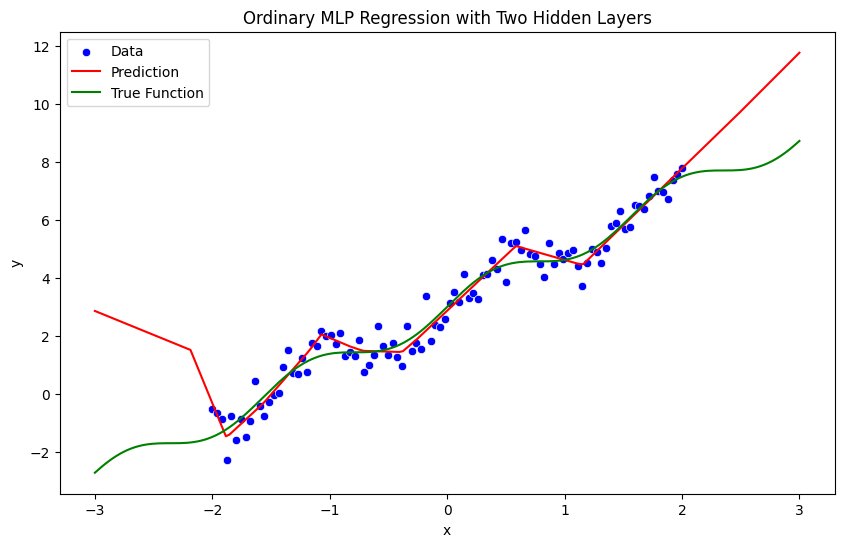

In [12]:
# Define the Ordinary MLP Model with two hidden layers
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the model
model = MLP(input_dim=1, hidden_dim1=10, hidden_dim2=10, output_dim=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 10000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(x_data)

    # Compute the loss
    loss = criterion(y_pred, y_data)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

# Visualize the results
model.eval()
with torch.no_grad():
    x_test = torch.linspace(-3, 3, 200).unsqueeze(1)
    y_pred = model(x_test).detach().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_data.squeeze().numpy(), y=y_data.squeeze().numpy(), color='blue', label='Data')
sns.lineplot(x=x_test.squeeze().numpy(), y=y_pred.squeeze(), color='red', label='Prediction')
plt.plot(x_test, true_function(x_test), color='green', label='True Function')
plt.legend()
plt.title('Ordinary MLP Regression with Two Hidden Layers')
plt.xlabel('x')
plt.ylabel('y')
plt.show()